# Simple baseline GDP

## Pre-requisite : declaring Fred API KEY

Following command will add `FRED_API_KEY` to your `zsh` environment, this has to be done at least once.

    echo 'export FRED_API_KEY=your_API_key_here' >> ~/.zshenv
    
Then make sure your restart your terminal/Jupyter notebook to make sure this change is effective.

You should now be able to print your key when executing the following

    echo $FRED_API_KEY

In [1]:
from fredapi import Fred

In [2]:
fred = Fred()

## Real Gross Domestic Product series overview

In [3]:
gdpc1 = fred.get_series('GDPC1')

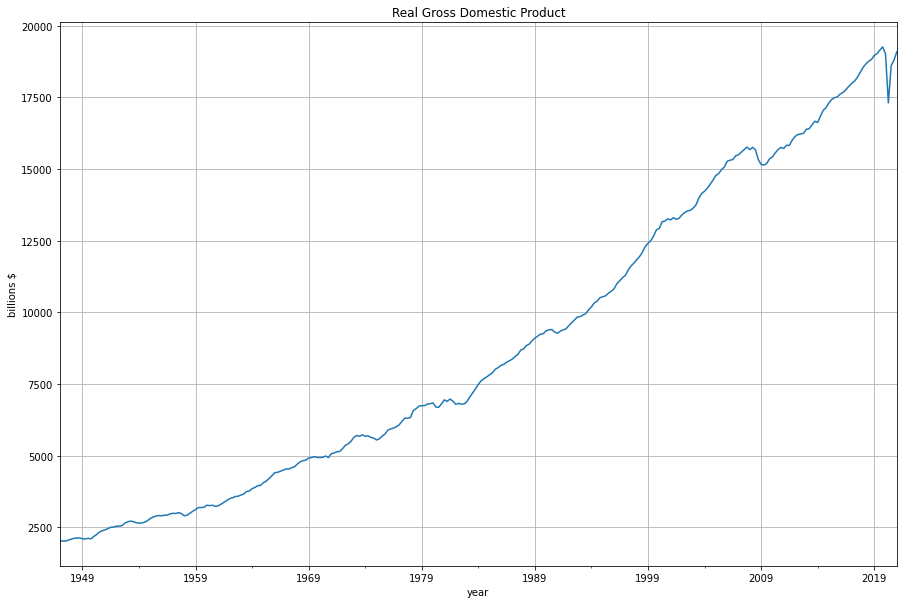

In [4]:
gdpc1.plot(
    title='Real Gross Domestic Product',
    figsize=(15, 10),
    xlabel='year',
    ylabel='billions $',
    grid=True,
);


## Baseline:
1-> predit = previous
2-> predict =linear interp 
3->polynomiale interp

In [5]:
from scipy.interpolate import PchipInterpolator

def polyextrapolate(datas,n): 
    '''
    polynom extrapolation of a padans serie on points
    '''
    datas=datas.reset_index(drop=True)
    result=[]
    
    for i in range (n, len(datas)):
        interpo=PchipInterpolator(datas.index[i-n:i],datas[i-n:i],extrapolate=True)
        extrapolated_result=interpo(datas.index[i])
        result.append(extrapolated_result.item(0))
    result=pd.Series(result)
    
    for i in range(n):
        result=result.append(pd.Series([-1]))
        result=result.shift(1)
    return result.values

In [6]:
import pandas as pd
gdp_base=pd.DataFrame(
    {
    'gdp': gdpc1[gdpc1.index],
    'gdp_previous':gdpc1.shift(1).values,
    'gdp_linear':(gdpc1.diff().shift(1)+gdpc1.shift(1)),
    'gdp_poly_extra':polyextrapolate(gdpc1,3)
    },
    index=gdpc1.index,
    )

In [7]:
gdp_base.head(5)

,gdp,gdp_previous,gdp_linear,gdp_poly_extra
1947-01-01,2033.061,NaN,NaN,NaN
1947-04-01,2027.639,2033.061,NaN,NaN
1947-07-01,2023.452,2027.639,2022.217,NaN
1947-10-01,2055.103,2023.452,2019.265,2020.658729
1948-01-01,2086.017,2055.103,2086.754,2095.128000


In [8]:
MAE_prev=abs(gdp_base.gdp-gdp_base.gdp_previous).mean()
MAE_lin=abs(gdp_base.gdp-gdp_base.gdp_linear).mean()
MAE_poly=abs(gdp_base.gdp-gdp_base.gdp_poly_extra).mean()

RMSE_prev=((gdp_base.gdp-gdp_base.gdp_previous)**2).mean()**.5
RMSE_lin=((gdp_base.gdp-gdp_base.gdp_linear)**2).mean()**.5
RMSE_poly=((gdp_base.gdp-gdp_base.gdp_poly_extra)**2).mean()**.5

print(f'MAE prev :  {round(MAE_prev)},    MAE_lin : {round(MAE_lin)},    MAE_poly {round(MAE_poly)}')
print(f'RMSE prev : {round(RMSE_prev)},   RMSE_lin : {round(RMSE_lin)},   RMSE_poly {round(RMSE_poly)}')

MAE prev :  85,    MAE_lin : 75,    MAE_poly 116
RMSE prev : 155,   RMSE_lin : 218,   RMSE_poly 357


## Statistical inference modelling using ARIMA

### Decomposing the series

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [10]:
decomposed_add = seasonal_decompose(gdpc1, model='additive')
decomposed_mul = seasonal_decompose(gdpc1, model='multiplicative')

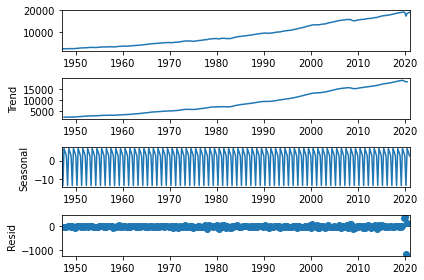

In [11]:
decomposed_add.plot();

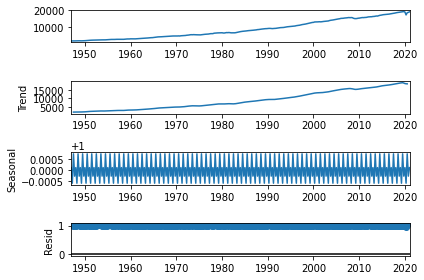

In [12]:
decomposed_mul.plot();

In [13]:
import matplotlib.pyplot as plt

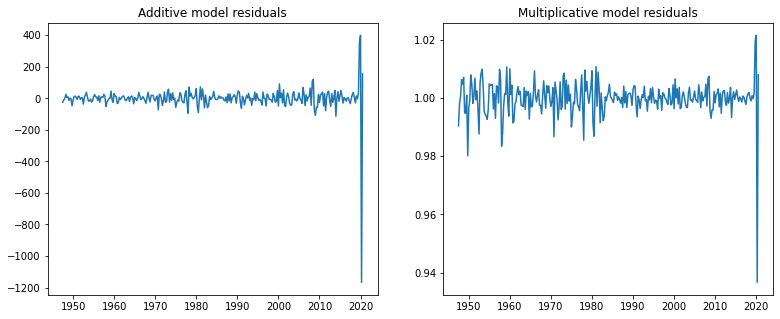

In [14]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,5))
ax1.plot(decomposed_add.resid); ax1.set_title('Additive model residuals')
ax2.plot(decomposed_mul.resid); ax2.set_title('Multiplicative model residuals');

In [15]:
from statsmodels.tsa.stattools import adfuller

In [16]:
adfuller(decomposed_add.resid.dropna())[1], adfuller(decomposed_mul.resid.dropna())[1]

(1.4152833925977054e-13, 3.101893078617219e-11)

**Additive decomposition** shows better ADfuller score, let's use this method.

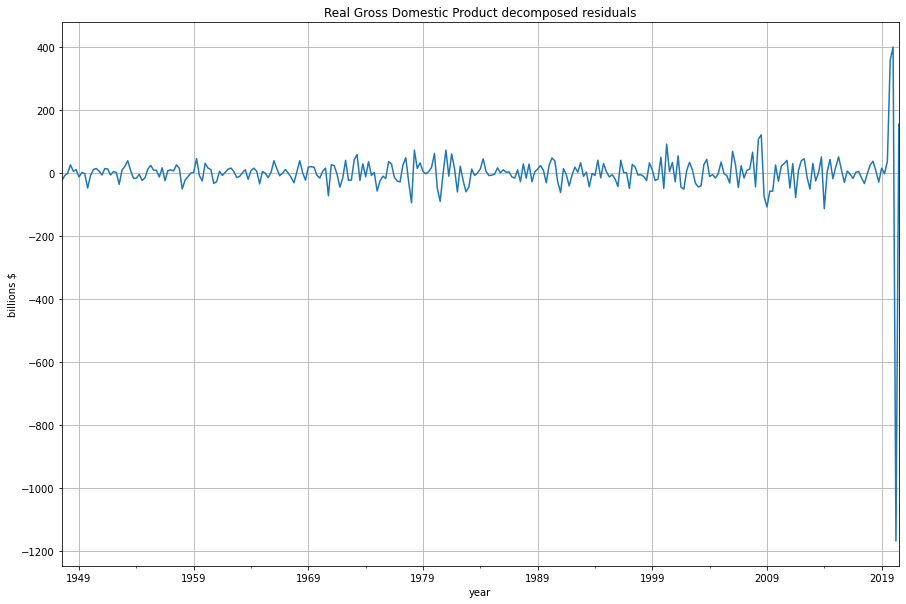

In [17]:
decomposed_resid = decomposed_add.resid.dropna()
decomposed_resid.plot(
    title='Real Gross Domestic Product decomposed residuals',
    figsize=(15, 10),
    xlabel='year',
    ylabel='billions $',
    grid=True,
);

### Differentiating

In [18]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [19]:
gdpc1_d1 = gdpc1.diff()[1:]
gdpc1_d2 = gdpc1_d1.diff()[1:]

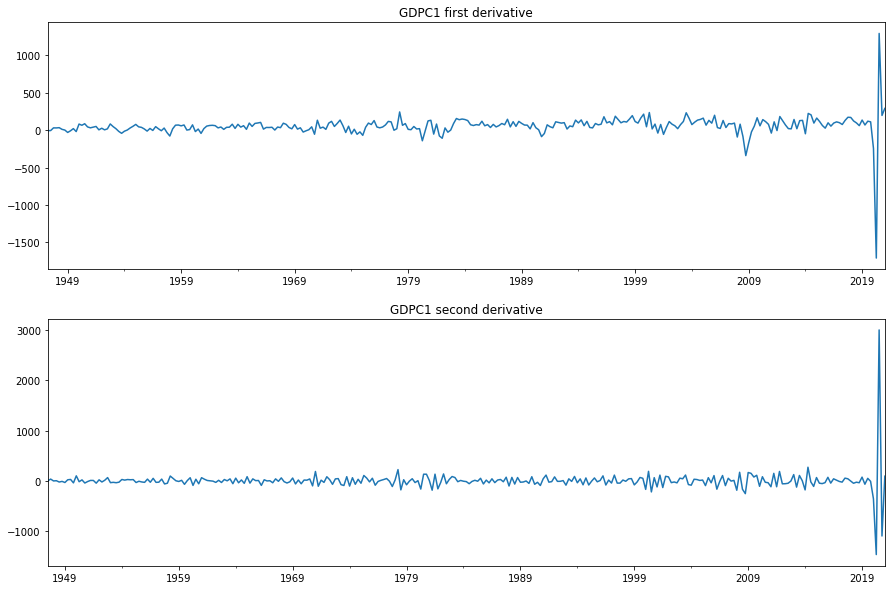

In [20]:
plt.subplots(2, 1, figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.title('GDPC1 first derivative')
gdpc1_d1.plot()

plt.subplot(2, 1, 2)
plt.title('GDPC1 second derivative')
gdpc1_d2.plot()
plt.show()

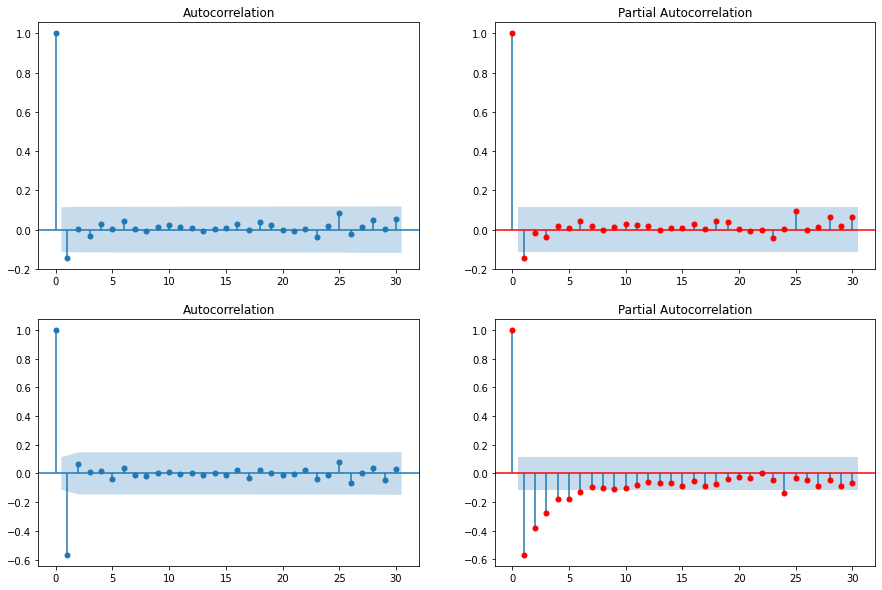

In [21]:
plt.subplots(2, 2, figsize=(15, 10))
plot_acf(gdpc1_d1, lags=30, ax=plt.subplot(2, 2, 1))
plot_pacf(gdpc1_d1, lags=30, ax=plt.subplot(2, 2, 2), color='r')
plot_acf(gdpc1_d2, lags=30, ax=plt.subplot(2, 2, 3))
plot_pacf(gdpc1_d2, lags=30, ax=plt.subplot(2, 2, 4), color='r')
plt.show()

In [22]:
print(
    f'diff d=1, adfuller p-value: {adfuller(gdpc1_d1)[1]}\n'
    f'diff d=2, adfuller p-value: {adfuller(gdpc1_d2)[1]}'
)

diff d=1, adfuller p-value: 0.0
diff d=2, adfuller p-value: 2.545079547784993e-14


Based on those metrics, we can infer the following ARIMA coefficients:
 - `d=2`: a differentiation of order `2` is enough to stabilize the series,
 - `q=2`: according to ACF
 - `p=6`: according to PACF

## Modelling

### Train / test split

In [113]:
year_cut = 2018
gdpc1_train = gdpc1[gdpc1.index.year < year_cut]
gdpc1_test = gdpc1[gdpc1.index.year >= year_cut]
len(gdpc1_train), len(gdpc1_test)

(284, 13)

### ARIMA modelling

In [24]:
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [25]:
p=6
d=2
q=2
model = ARIMA(gdpc1_train, (p, d, q)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                  282
Model:                 ARIMA(6, 2, 2)   Log Likelihood               -1557.684
Method:                       css-mle   S.D. of innovations             60.111
Date:                Thu, 01 Jul 2021   AIC                           3135.369
Time:                        17:47:35   BIC                           3171.788
Sample:                    07-01-1947   HQIC                          3149.973
                         - 10-01-2017                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2764      0.073      3.779      0.000       0.133       0.420
ar.L1.D2.y    -0.6843      0.072     -9.559      0.000      -0.825      -0.544
ar.L2.D2.y     0.4493      0.073      6.142      0.000       0.306       0.593
ar.L3.D2.y     0.1833      0.077      2.374      0.018       0.032       0.335
ar.L4.D2.y     0.0072      0.077      0.094      0.925      -0.143       0.158
ar.L5.D2.y    -0.0753      0.072     -1.046      0.295      -0.216       0.066
ar.L6.D2.y    -0.0539      0.060     -0.900      0.368      -0.171       0.063
ma.L1.D2.y    -0.0265      0.041     -0.652      0.515      -0.106       0.053
ma.L2.D2.y    -0.9734      0.041    -23.993      0.000      -1.053      -0.894
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4375           -0.6395j            1.5734           -0.0666
AR.2            1.4375           +0.6395j            1.5734            0.0666
AR.3           -1.0189           -0.0000j            1.0189           -0.5000
AR.4           -0.6606           -1.8359j            1.9511           -0.3050
AR.5           -0.6606           +1.8359j            1.9511            0.3050
AR.6           -1.9334           -0.0000j            1.9334           -0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.0272           +0.0000j            1.0272            0.5000
-----------------------------------------------------------------------------
"""

Our p-values are quite high, meaning our trust in that baseline model is pretty limited.

### Forecast

In [26]:
import pandas as pd
import numpy as np

In [27]:
forecast, stderr, conf = model.forecast(len(gdpc1_test))

In [28]:
gdpc1_forecast = pd.DataFrame(
    {
        'truth': gdpc1[gdpc1_test.index],
        'forecast': forecast,
        'err': gdpc1[gdpc1_test.index] - forecast,
        'stderr': stderr,
        'conf_inf': conf[:,0],
        'conf_sup': conf[:,1],
    },
    index=gdpc1_test.index,
)
gdpc1_forecast

,truth,forecast,err,stderr,conf_inf,conf_sup
2018-01-01,18530.483,18480.727210,49.755790,60.110771,18362.912263,18598.542156
2018-04-01,18654.383,18600.493440,53.889560,98.074866,18408.270234,18792.716646
2018-07-01,18752.355,18708.584818,43.770182,134.889314,18444.206621,18972.963016
2018-10-01,18813.923,18812.166863,1.756137,168.569774,18481.776176,19142.557550
2019-01-01,18950.347,18907.122270,43.224730,198.969387,18517.149438,19297.095103
2019-04-01,19020.599,19005.809867,14.789133,224.852152,18565.107746,19446.511987
2019-07-01,19141.744,19100.424776,41.319224,247.986265,18614.380628,19586.468924
2019-10-01,19253.959,19199.176151,54.782849,268.560491,18672.807261,19725.545041
2020-01-01,19010.848,19295.181964,-284.333964,287.440281,18731.809365,19858.554563
2020-04-01,17302.511,19395.422591,-2092.911591,304.795694,18798.034008,19992.811175


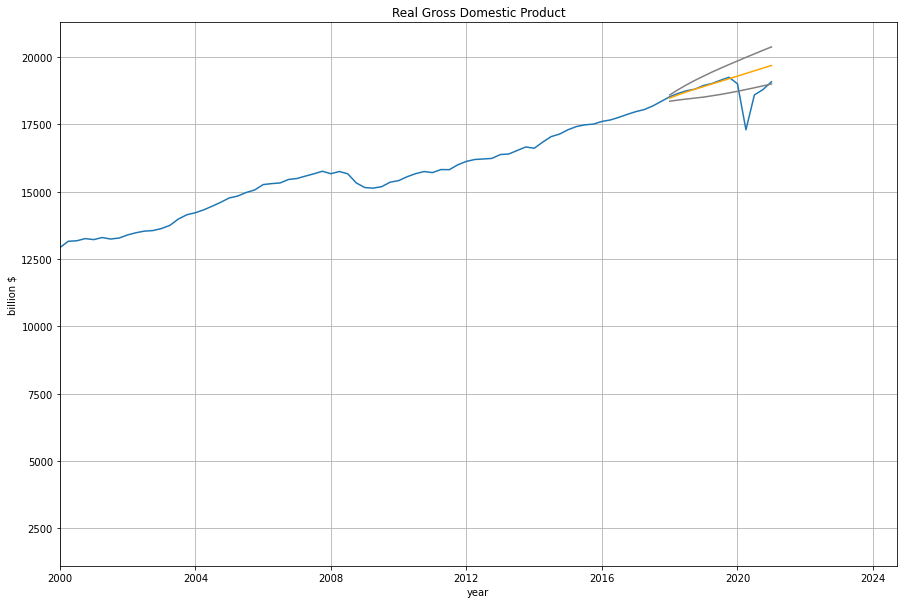

In [29]:
plt.subplots(1, 1, figsize=(15, 10))
plt.title('Real Gross Domestic Product')
plt.plot(gdpc1, label='truth')
plt.plot(gdpc1_forecast.forecast, color='orange')
plt.plot(gdpc1_forecast.conf_inf, color='gray')
plt.plot(gdpc1_forecast.conf_sup, color='gray');
plt.xlabel('year')
plt.ylabel('billion $')
plt.grid()
plt.xlim(left=np.datetime64('2000', 'ns'));

## Auto Arima

### nombre optimal de derivations 

In [30]:
from pmdarima.arima.utils import ndiffs
ndiffs(gdpc1)

2

### auto arima

In [31]:
import pmdarima as pm

In [32]:
smodel = pm.auto_arima(gdpc1_train,
                       start_p=1, max_p=6,
                       start_q=1, max_q=4,
                       seasonal=False,
                       trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=3235.984, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=3178.166, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=3152.686, Time=0.06 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=3234.005, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=3150.806, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=3135.825, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=3176.210, Time=0.04 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=3130.036, Time=0.13 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=3168.161, Time=0.04 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=3132.033, Time=0.19 sec
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=3132.034, Time=0.21 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=3131.4

In [33]:
#auto arima  best model with (2,2,1) ou (0,2,2)

In [34]:
p=2
d=2
q=1
final_model = ARIMA(gdpc1_train, (p, d, q)).fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                  282
Model:                 ARIMA(2, 2, 1)   Log Likelihood               -1558.561
Method:                       css-mle   S.D. of innovations             60.322
Date:                Thu, 01 Jul 2021   AIC                           3127.123
Time:                        17:47:39   BIC                           3145.333
Sample:                    07-01-1947   HQIC                          3134.425
                         - 10-01-2017                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2780      0.080      3.492      0.000       0.122       0.434
ar.L1.D2.y     0.2898      0.059      4.921      0.000       0.174       0.405
ar.L2.D2.y     0.1652      0.059      2.807      0.005       0.050       0.281
ma.L1.D2.y    -1.0000      0.010   -102.658      0.000      -1.019      -0.981
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7348           +0.0000j            1.7348            0.0000
AR.2           -3.4886           +0.0000j            3.4886            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

### reforecast

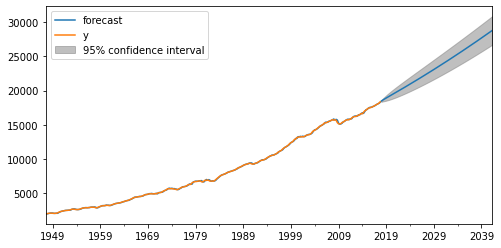

In [35]:
final_model.plot_predict(end=297+4*20,dynamic=False);
fig = plt.gcf(); fig.set_size_inches(8, 4)

### Check residuals for inference validity

In [36]:
#
#

# cross validate performance and cv search on parameters

In [37]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
import itertools
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [169]:
%%time
n_splits=5
max_train_size=40
test_size=2

range_p = [0,1,2]
range_d = [1,2]
range_q = [0,1,2]
grid = itertools.product(range_p, range_d, range_q)

orders = []
r2s = []
aics = []
fold_idxs = []
RMSE=[]
MAE=[]

for (p,d,q) in grid:
    order = (p,d,q)    
    folds = TimeSeriesSplit (n_splits=n_splits,max_train_size=max_train_size,test_size=test_size)
    
    for fold_idx, (train_idx, test_idx) in enumerate(folds.split(gdpc1_train)):
        try : 
            fold_idxs.append(fold_idx)
            y_train = np.array(gdpc1[train_idx])
            y_test = np.array(gdpc1[test_idx])
            model = ARIMA(y_train, order=order).fit()            
            forecast, std_err, confidence_int = model.forecast(len(y_test), alpha=0.05)           
            orders.append(order)
            aics.append(model.aic)
            #print(f'y_test={y_test}  forecast = {forecast}',list(abs(y_test-forecast)))
            RMSE.append(mean_squared_error(y_test,forecast ,squared=False))
            MAE.append(abs(y_test-forecast).mean())           
        except : 
            print(f'cannot run ARIMA (p,d,q)= ({p}, {d}, {q}),fold_idx={fold_idx} , test_idx={test_idx} ')

      

cannot run ARIMA (p,d,q)= (1, 1, 2),fold_idx=0 , test_idx=[274 275] 
cannot run ARIMA (p,d,q)= (1, 2, 2),fold_idx=4 , test_idx=[282 283] 
cannot run ARIMA (p,d,q)= (2, 1, 2),fold_idx=4 , test_idx=[282 283] 
cannot run ARIMA (p,d,q)= (2, 2, 2),fold_idx=4 , test_idx=[282 283] 
CPU times: user 5.22 s, sys: 8.19 ms, total: 5.23 s
Wall time: 5.21 s


In [179]:
df = pd.DataFrame(list(zip(fold_idxs, orders, aics,RMSE,MAE)),columns =['Fold', '(p,d,q)', 'AIC','RMSE','MAE'])  #, 'R2'])

In [174]:
df.sort_values('AIC').groupby('(p,d,q)').mean()['AIC'].sort_values()

(p,d,q)
(1, 2, 1)    465.811686
(0, 2, 2)    466.374472
(0, 2, 1)    467.687427
(1, 2, 2)    468.104508
(2, 2, 1)    469.788221
(2, 2, 2)    470.197964
(2, 2, 0)    470.631347
(1, 2, 0)    471.095401
(1, 1, 0)    473.976203
(0, 2, 0)    474.788868
(0, 1, 1)    475.036553
(1, 1, 1)    475.634534
(2, 1, 0)    475.643015
(0, 1, 2)    476.545764
(1, 1, 2)    477.051155
(2, 1, 1)    477.611481
(0, 1, 0)    477.905869
(2, 1, 2)    481.235808
Name: AIC, dtype: float64

In [175]:
df.sort_values('MAE').groupby('(p,d,q)').mean()['MAE'].sort_values()

(p,d,q)
(0, 2, 2)    38.508349
(1, 2, 1)    40.341315
(2, 1, 2)    40.368273
(1, 2, 2)    44.201038
(2, 2, 2)    47.820037
(0, 2, 1)    50.273684
(2, 2, 1)    56.569716
(0, 1, 0)    58.833495
(0, 1, 2)    59.888955
(2, 1, 0)    60.041338
(1, 1, 0)    60.139261
(1, 1, 1)    60.162017
(0, 1, 1)    60.170691
(2, 1, 1)    60.174805
(1, 1, 2)    61.102995
(2, 2, 0)    61.567348
(1, 2, 0)    70.152695
(0, 2, 0)    78.404226
Name: MAE, dtype: float64

In [176]:
df.sort_values('RMSE').groupby('(p,d,q)').mean()['RMSE'].sort_values()

(p,d,q)
(2, 1, 2)    44.263064
(0, 2, 2)    44.777953
(1, 2, 1)    45.380886
(1, 2, 2)    49.061432
(2, 2, 2)    54.783960
(0, 2, 1)    56.001883
(2, 2, 1)    61.899231
(0, 1, 0)    63.784630
(0, 1, 2)    64.402608
(2, 1, 0)    64.633657
(1, 1, 0)    64.661845
(1, 1, 1)    64.764295
(0, 1, 1)    64.787749
(2, 1, 1)    64.792268
(1, 1, 2)    65.412476
(2, 2, 0)    66.945069
(1, 2, 0)    76.551831
(0, 2, 0)    84.991836
Name: RMSE, dtype: float64

best model for 1st prediction (0, 2, 1), or (2,2,0) ; (0,2,2); (1,2,1)  !! 
best model for 2 predictions (0, 2, 1)
=> cv search best number of historical value 

In [177]:
max_train_sizes=range(2,48,2)

n_splits=100
test_size=1

p=0 ; d=2 ; q=1

aics = []
fold_idxs = []
RMSEs=[]
MAEs=[]
Train_size=[]

In [178]:
%%time
for max_train_size in max_train_sizes:
    RMSE=[]
    MAE=[]
    folds = TimeSeriesSplit(n_splits=n_splits,max_train_size=max_train_size,test_size=test_size)
    for fold_idx, (train_idx, test_idx) in enumerate(folds.split(gdpc1_train)):
        try : 
            RMSE=[]
            MAE=[] 
            fold_idxs.append(fold_idx)
            y_train = gdpc1[train_idx]
            y_test = gdpc1[test_idx]
            model = ARIMA(y_train, order=order).fit()
            forecast, std_err, confidence_int = model.forecast(len(y_test), alpha=0.05)
            RMSE.append(mean_squared_error(y_test,forecast ,squared=False))
            MAE.append(abs(y_test-forecast).mean())           
        except : 
            print(f'could not run ARIMA with (p,d,q) = ({p}, {d}, {q} and max_train_size= {max_train_size}')
            
    RMSEs.append(np.array(RMSE).mean())
    MAEs.append(np.array(MAE).mean())
    Train_size.append(max_train_size)
      
      

could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 2
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 2
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 2
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 2
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 2
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 2
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 2
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 2
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 2
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 2
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 2
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 2
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 2
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 2
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 2
could not 

could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 8
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 8
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 8
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 8
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 8
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 8
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 8
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 8
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 8
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 8
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 8
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 8
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 8
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 8
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 8
could not 

could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 10
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 10
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 10
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 10
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 10
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 10
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 10
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 10
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 10
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 10
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 10
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 10
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 10
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 10
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size

could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 14
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 14
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 14
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 14
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 14
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 14
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 14
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 14
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 14
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 14
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 14
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 14
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 14
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 14
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size

could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 16
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 16
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 16
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 16
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 16
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 16
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 16
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 16
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 16
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 16
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 16
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 16
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 16
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 16
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size

could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 20
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 20
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 20
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 20
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 20
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 20
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 20
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 20
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 20
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 20
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 20
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 20
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 20
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 20
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size

could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 26
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 26
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 26
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 26
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 26
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 26
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 28
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 28
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 28
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 28
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 28
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 28
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 28
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size= 28
could not run ARIMA with (p,d,q) = (0, 2, 1 and max_train_size

In [180]:
RMSEs,MAEs,Train_size

([nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  35.81932929226605,
  42.983080241185235,
  31.109599669067393,
  47.17770682469927,
  nan,
  71.40825774462428,
  79.75409412734734,
  nan,
  nan,
  nan,
  nan,
  43.61143756733509,
  47.04664412749844,
  60.66380561068581],
 [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  35.81932929226605,
  42.983080241185235,
  31.109599669067393,
  47.17770682469927,
  nan,
  71.40825774462428,
  79.75409412734734,
  nan,
  nan,
  nan,
  nan,
  43.61143756733509,
  47.04664412749844,
  60.66380561068581],
 [2,
  4,
  6,
  8,
  10,
  12,
  14,
  16,
  18,
  20,
  22,
  24,
  26,
  28,
  30,
  32,
  34,
  36,
  38,
  40,
  42,
  44,
  46,
  48])